En esta actividad, se desarrollará un modelo de red neuronal para clasificar los dígitos escritos a mano del conjunto de datos MNIST. El ejercicio incluye entrenar un modelo utilizando imágenes de dígitos, evaluar su desempeño en los conjuntos de entrenamiento y validación, y luego comparar los resultados obtenidos en el conjunto de prueba. Posteriormente, se generarán y preprocesarán 50 imágenes (5 para cada dígito), las cuales se utilizarán para probar el modelo. Se evaluará el rendimiento del modelo en estas nuevas imágenes, comparando las predicciones con los resultados reales. Además, se implementarán tres mejoras o adiciones al sistema actual para optimizar su capacidad predictiva. Finalmente, se creará un sistema que permita la predicción de dígitos en tiempo real utilizando imágenes capturadas por la cámara, con el objetivo de mejorar tanto el modelo como el proceso de preprocesamiento de imágenes.

In [9]:
# Basic imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(f"{tf.__version__}")
import cv2
print(f"{cv2.__version__}")

2.18.0
4.11.0


En esta parte, cargaré el conjunto de datos MNIST usando TensorFlow. Este conjunto contiene imágenes de dígitos escritos a mano, del 0 al 9, y lo dividiré en dos partes: entrenamiento y prueba. Para que el modelo aprenda mejor, normalizaré las imágenes, es decir, convertiré los valores de los píxeles de 0-255 a un rango de 0 a 1. Luego, mostraré algunas imágenes de ejemplo junto con sus etiquetas para asegurarme de que todo se haya cargado correctamente. También revisaré la cantidad de imágenes en los conjuntos de entrenamiento y prueba, y verificaré que la distribución de los dígitos esté balanceada.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Tamaño del conjunto de entrenamiento: (60000, 28, 28)
Tamaño del conjunto de prueba: (10000, 28, 28)
Rango de valores en x_train: mínimo = 0.0 , máximo = 1.0

Distribución de clases en el conjunto de entrenamiento:
Dígito 0: 5923 imágenes
Dígito 1: 6742 imágenes
Dígito 2: 5958 imágenes
Dígito 3: 6131 imágenes
Dígito 4: 5842 imágenes
Dígito 5: 5421 imágenes
Dígito 6: 5918 imágenes
Dígito 7: 6265 imágenes
Dígito 8: 5851 imágenes
Dígito 9: 5949 imágenes


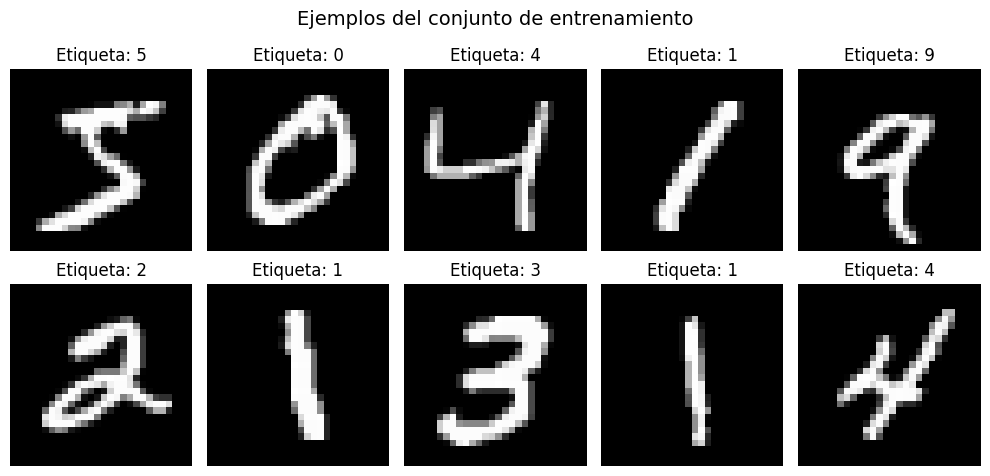

In [10]:
# Cargar el conjunto de datos MNIST
import numpy as np
# Se descarga el dataset y se divide en train y test
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalizar los datos (0 o 1)
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Comprobar la cantidad de imágenes y su tamaño
print("Tamaño del conjunto de entrenamiento:", x_train.shape)
print("Tamaño del conjunto de prueba:", x_test.shape)

# Rango de los valores de pixel
print("Rango de valores en x_train: mínimo =", np.min(x_train), ", máximo =", np.max(x_train))

# Se revisa la proporción de las clases
import collections
train_labels_count = collections.Counter(y_train)
print("\nDistribución de clases en el conjunto de entrenamiento:")
for label in sorted(train_labels_count.keys()):
    print(f"Dígito {label}: {train_labels_count[label]} imágenes")

# Se visualizan imagenes de ejemplo del conjunto de entrenamiento ( con distintos numeros )
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("Ejemplos del conjunto de entrenamiento", fontsize=14)
for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title(f"Etiqueta: {y_train[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

En esta parte, importo los módulos necesarios de Keras para crear y entrenar la red neuronal. Utilizo TensorFlow y las clases específicas de Keras como Sequential, Flatten, Dense y EarlyStopping. Luego, genero la red neuronal utilizando el modelo secuencial de Keras. La primera capa, Flatten, convierte las imágenes de 28x28 píxeles en un vector de 784 valores, lo cual es necesario para que las redes neuronales densas procesen las imágenes correctamente. A continuación, agrego dos capas densas con 128 y 64 neuronas, respectivamente, usando la función de activación ReLU para introducir no linealidad. Finalmente, la capa de salida tiene 10 neuronas, una para cada dígito (0-9), y utiliza la función de activación softmax, que convierte las salidas en probabilidades y es adecuada para problemas de clasificación multiclase.

In [11]:
# se importan modulos de keras

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

# A continuación se genera la Red neuronal
model = Sequential()
model.add(Flatten(input_shape=(28, 28))) # Aplana todas las imagenes en un vector largo
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))  # 10 clases, una por dígito

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Primero, compilo el modelo para prepararlo para el entrenamiento. Uso el optimizador Adam con una tasa de aprendizaje de 0.001, que ayuda a ajustar los pesos del modelo de manera eficiente. La función de pérdida sparse_categorical_crossentropy se usa porque estamos trabajando con un problema de clasificación de varios dígitos (0-9). También configuro la precisión como métrica para saber qué tan bien está funcionando el modelo.

Después, agrego EarlyStopping, lo que significa que si el modelo no mejora su rendimiento después de 5 épocas, el entrenamiento se detendrá para evitar el sobreajuste.

Luego, entreno el modelo usando los datos de entrenamiento (x_train, y_train). Durante el entrenamiento, el 20% de los datos se usarán para validación, para ver si el modelo está generalizando bien. Se entrena por hasta 50 épocas, pero si el rendimiento no mejora, se detiene antes.

Finalmente, uso model.summary() para ver un resumen de la estructura del modelo, es decir, cuántas capas tiene y cuántos parámetros están siendo ajustados.



In [12]:
# Compilar el modelo
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Entrenar
# Replacing 'train_images' and 'train_labels' with 'x_train' and 'y_train' respectively
history = model.fit(x_train, y_train,
                    epochs=50,
                    validation_split=0.2,
                    batch_size=32,
                    callbacks=[early_stop])

model.summary()

Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8667 - loss: 0.4640 - val_accuracy: 0.9580 - val_loss: 0.1395
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9642 - loss: 0.1182 - val_accuracy: 0.9657 - val_loss: 0.1103
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9760 - loss: 0.0786 - val_accuracy: 0.9711 - val_loss: 0.0973
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9832 - loss: 0.0549 - val_accuracy: 0.9706 - val_loss: 0.1020
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9853 - loss: 0.0447 - val_accuracy: 0.9729 - val_loss: 0.0923
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9892 - loss: 0.0323 - val_accuracy: 0.9736 - val_loss: 0.0982
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9925 - loss: 0.0253 - val_accuracy: 0.9741 - val_loss: 0.1041
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9926 - loss: 0.0228 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,160 (1.25 MB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 218,774 (854.59 KB)

En esta parte, visualizo el desempeño del modelo durante el entrenamiento mediante dos gráficas: una para precisión y otra para pérdida. La gráfica de precisión muestra cómo ha mejorado la capacidad del modelo para clasificar correctamente los dígitos en los conjuntos de entrenamiento y validación a lo largo de las épocas. La precisión indica qué tan bien el modelo está prediciendo los dígitos. Por otro lado, la gráfica de pérdida muestra cómo ha cambiado la medida de error del modelo durante el entrenamiento. La pérdida nos dice cuán cerca o lejos están las predicciones del modelo de las respuestas correctas, y el objetivo es que esta disminuya conforme el modelo mejora. Ambas gráficas muestran en el eje x el número de épocas (el número de ciclos de entrenamiento) y en el eje y el valor de precisión o pérdida en cada época. Finalmente, utilizo plt.show() para mostrar estas gráficas y así poder analizar el rendimiento del modelo durante el entrenamiento y su comportamiento en el conjunto de validación.



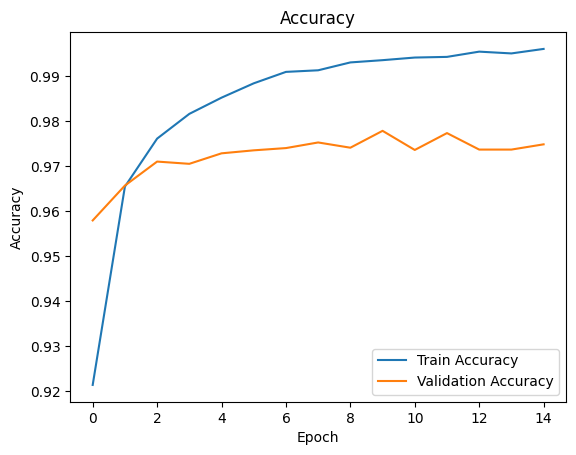

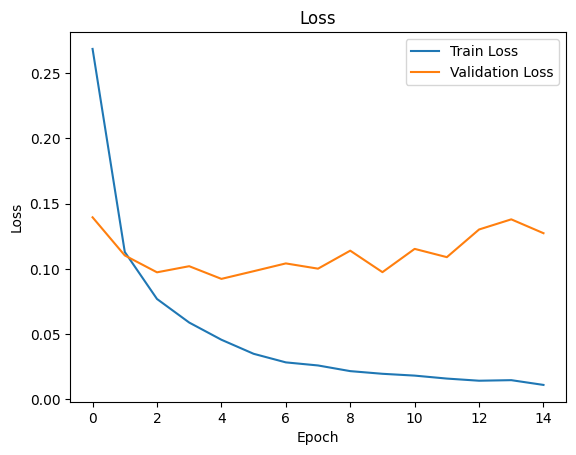

In [13]:
# Por ultimo la visualización del modelo
# Exactitud
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

En las gráficas obtenidas, la precisión de entrenamiento sube rápidamente y se estabiliza cerca del 100%, lo que indica que el modelo está aprendiendo bien. La precisión de validación también aumenta, aunque un poco más despacio, y se mantiene cerca del 97%, lo que muestra que el modelo generaliza bien a los datos nuevos. Sin embargo, la pérdida de entrenamiento baja de forma constante, lo que significa que el modelo está mejorando, pero la pérdida de validación tiene algunas fluctuaciones al final, lo que podría ser un indicio de que el modelo empieza a sobreajustarse. A pesar de eso, el modelo sigue funcionando bastante bien sin grandes problemas de sobreajuste.

In [14]:
# Guardar el primer modelo
model.save("modelo1.keras")

En esta parte del proyecto, monté mi Google Drive para poder acceder a la carpeta donde tenía guardadas las imágenes escritas a mano. Después, definí la ruta hacia la carpeta "numeros" y creé dos listas vacías para almacenar las imágenes procesadas y sus etiquetas correspondientes. Luego, recorrí cada carpeta (de num0 a num9), cargando cada imagen en escala de grises, redimensionándola a 28x28 pixeles, normalizándola entre 0 y 1, y añadiendo una dimensión extra para que el modelo pudiera leerlas correctamente. Finalmente, convertí las listas a arreglos de NumPy y mostré cuántas imágenes y etiquetas se habían cargado en total.



In [20]:
import cv2
import numpy as np
import os
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

ruta_base = '/content/drive/MyDrive/NUM'

# Validar ruta base
if not os.path.exists(ruta_base):
    print(f"Error: Directory '{ruta_base}' not found. Please verify the path.")
else:
    imagenes = []
    etiquetas = []


    for digito in range(10):
        ruta_digito = os.path.join(ruta_base, f'num{digito}')

        if not os.path.exists(ruta_digito):
            print(f"Carpeta no encontrada: {ruta_digito}, se omite.")
            continue

        for nombre_archivo in os.listdir(ruta_digito):
            ruta_imagen = os.path.join(ruta_digito, nombre_archivo)

            if not os.path.isfile(ruta_imagen):
                print(f"Archivo no encontrado: {ruta_imagen}, se omite.")
                continue

            img = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)

            if img is None:
                print(f"Error leyendo la imagen {ruta_imagen}, se omite.")
                continue

            img = cv2.resize(img, (28, 28))
            img = img.astype('float32') / 255.0
            img = img.reshape(28, 28, 1)

            imagenes.append(img)
            etiquetas.append(digito)

    # Convertir a numpy después de cargar todo
    imagenes = np.array(imagenes)
    etiquetas = np.array(etiquetas)

    print("Total de imágenes cargadas:", imagenes.shape)
    print("Total de etiquetas:", etiquetas.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total de imágenes cargadas: (50, 28, 28, 1)
Total de etiquetas: (50,)


En esta parte del código, hago el procesamiento de las imágenes que capturé previamente. Primero creo dos listas vacías llamadas imagenes y etiquetas. Luego, recorro cada carpeta que corresponde a un número del 0 al 9, y por cada imagen dentro de esas carpetas realizo varios pasos: leo la imagen en escala de grises, elimino el ruido aplicando un filtro de mediana, aumento el contraste, aplico un suavizado gaussiano, binarizo la imagen para resaltar el número, y finalmente redimensiono la imagen a 28x28 pixeles, normalizándola entre 0 y 1. También acomodo la imagen para que tenga una sola dimensión de canal. Cada imagen ya procesada la agrego a la lista imagenes y le asigno su número correcto en la lista etiquetas. Al terminar, convierto las listas en arreglos de NumPy para poder utilizarlos directamente en el modelo.

In [22]:
imagenes = []
etiquetas = []

for digito in range(10):
    ruta_digito = os.path.join(ruta_base, f'num{digito}')
    for nombre_archivo in os.listdir(ruta_digito):
        ruta_imagen = os.path.join(ruta_digito, nombre_archivo)

        # Leer la imagen en escala de grises
        img = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)

        # Eliminar ruido aplicando un filtro de mediana
        img = cv2.medianBlur(img, 5)

        # Aumentar el contraste
        alpha = 2.0
        beta = 0
        img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

        # Suavizado Gaussiano
        img = cv2.GaussianBlur(img, (5, 5), 0)

        # Binarización
        _, thresh = cv2.threshold(img, 140, 255, cv2.THRESH_BINARY_INV)

        # Redimensionar
        img_resized = cv2.resize(thresh, (28, 28))

        # Normalizar
        img_resized = img_resized.astype('float32') / 255.0

        # Añadir la dimensión del canal
        img_resized = img_resized.reshape(28, 28, 1)

        # Guardar
        imagenes.append(img_resized)
        etiquetas.append(digito)

# Y ahora sí conviertes todo a numpy
imagenes = np.array(imagenes)
etiquetas = np.array(etiquetas)

print("Total de imágenes cargadas desde 'numeros':", imagenes.shape)

Total de imágenes cargadas desde 'numeros': (50, 28, 28, 1)


En esta parte del proyecto utilicé el modelo entrenado para hacer predicciones sobre las imágenes procesadas. Primero, generé las predicciones usando el modelo y luego obtuve la clase predicha para cada imagen. Después, comparé las predicciones con las etiquetas reales para ver cuántas coincidían. Al final, calculé el porcentaje de aciertos del modelo y mostré la precisión obtenida, lo cual me permitió evaluar qué tan bien funcionó el modelo reconociendo los dígitos escritos a mano.



In [23]:
# Hacer las predicciones sobre estas imágenes
predicciones = model.predict(imagenes)
predicciones_finales = np.argmax(predicciones, axis=1)

# Comparar predicciones y mostrar resultados
print("\nPredicciones reales vs. predicciones del modelo:\n")
for real, predicha in zip(etiquetas, predicciones_finales):
    print(f"Real: {real} | Predicho: {predicha}")

# Calcular el porcentaje de aciertos
correctas = np.sum(etiquetas == predicciones_finales)
total = etiquetas.shape[0]
accuracy = correctas / total

print(f"\nTotal de aciertos: {correctas} de {total}")
print(f"Precisión (accuracy): {accuracy * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step

Predicciones reales vs. predicciones del modelo:

Real: 0 | Predicho: 0
Real: 0 | Predicho: 9
Real: 0 | Predicho: 9
Real: 0 | Predicho: 0
Real: 0 | Predicho: 7
Real: 1 | Predicho: 1
Real: 1 | Predicho: 1
Real: 1 | Predicho: 1
Real: 1 | Predicho: 1
Real: 1 | Predicho: 1
Real: 2 | Predicho: 2
Real: 2 | Predicho: 2
Real: 2 | Predicho: 2
Real: 2 | Predicho: 2
Real: 2 | Predicho: 2
Real: 3 | Predicho: 3
Real: 3 | Predicho: 3
Real: 3 | Predicho: 3
Real: 3 | Predicho: 3
Real: 3 | Predicho: 3
Real: 4 | Predicho: 9
Real: 4 | Predicho: 4
Real: 4 | Predicho: 9
Real: 4 | Predicho: 4
Real: 4 | Predicho: 9
Real: 5 | Predicho: 3
Real: 5 | Predicho: 9
Real: 5 | Predicho: 3
Real: 5 | Predicho: 5
Real: 5 | Predicho: 5
Real: 6 | Predicho: 4
Real: 6 | Predicho: 6
Real: 6 | Predicho: 6
Real: 6 | Predicho: 6
Real: 6 | Predicho: 6
Real: 7 | Predicho: 2
Real: 7 | Predicho: 3
Real: 7 | Predicho: 3
Real: 7 | Predicho: 9
Real: 7 | Predicho: 9
Real: 8 | Predicho: 6
Real: 8 

Por último, las tres mejoras que apliqué en el código fueron, primero, el uso de un filtro de mediana para eliminar el ruido de la imagen, lo que ayuda a mejorar la calidad de la imagen antes de procesarla. Luego, aumenté el contraste de la imagen para hacer que los dígitos fueran más visibles y facilitar su identificación. Finalmente, apliqué un suavizado Gaussiano para suavizar los bordes y reducir cualquier detalle pequeño que pudiera afectar la binarización y la predicción. Estas tres mejoras ayudan a preparar mejor las imágenes y hacer que el modelo reconozca los dígitos con mayor precisión.

